Downloads the NYSE stock dataset from Kaggle using kagglehub and sets the path for further use

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,

import kagglehub
dgawlik_nyse_path = kagglehub.dataset_download('dgawlik/nyse')

print('Data source import complete.')

100%|██████████| 30.7M/30.7M [00:00<00:00, 43.9MB/s]

Extracting files...


Data source import complete.


Libraries are imported to handle data manipulation (pandas, numpy), data visualization (matplotlib, seaborn), machine learning models (scikit-learn, xgboost), and deep learning with LSTM (tensorflow.keras)

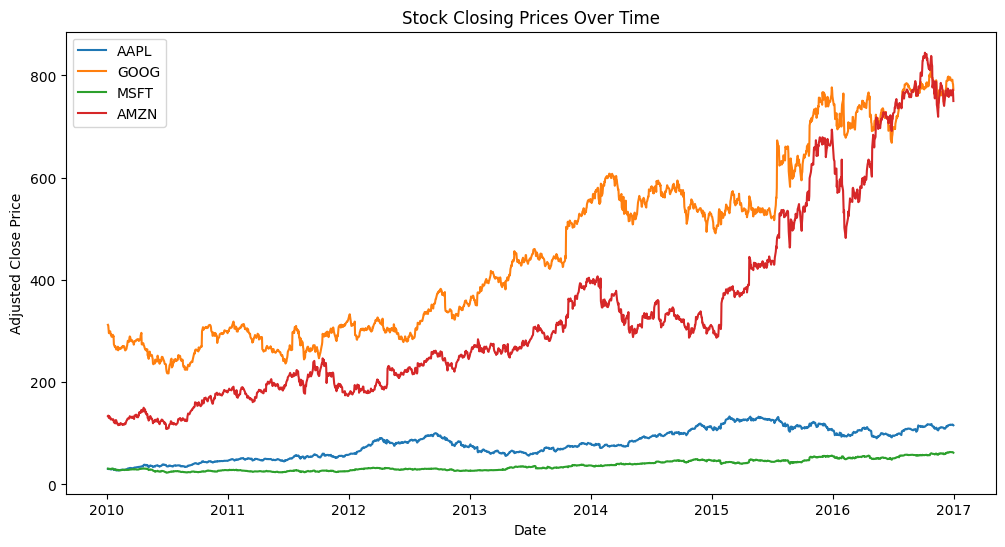

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3591.4360
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.5020
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.6747
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7455
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.6771
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.3805
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7705
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2264
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6822
Epoch 10/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2740
Epoch 11/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6291
Epoch 12/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7436
Epoch 13/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1233
Epoch 14/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6871
Epoch 15/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1115
Epoch 16/20
88/88 ━━━━━━━

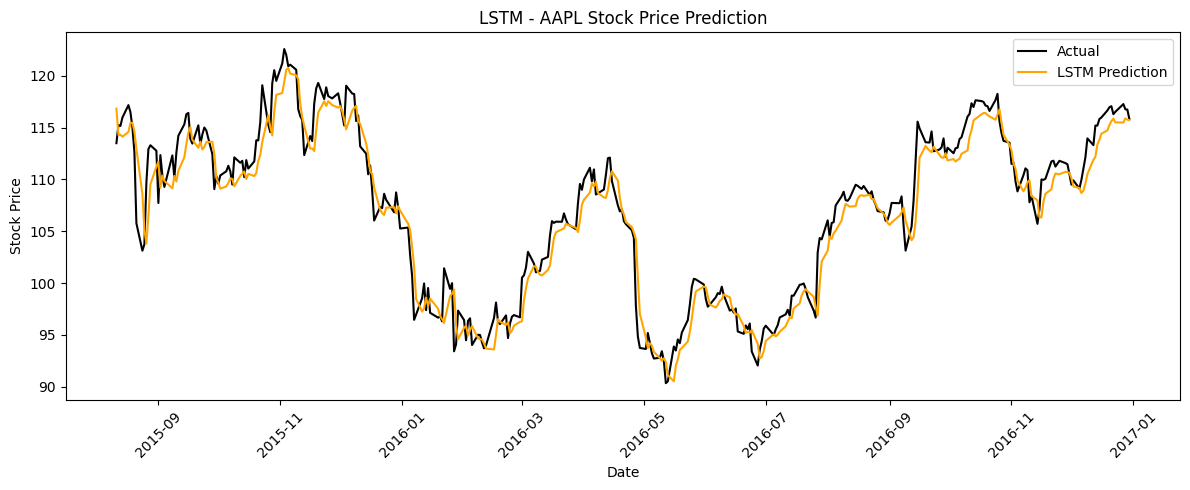

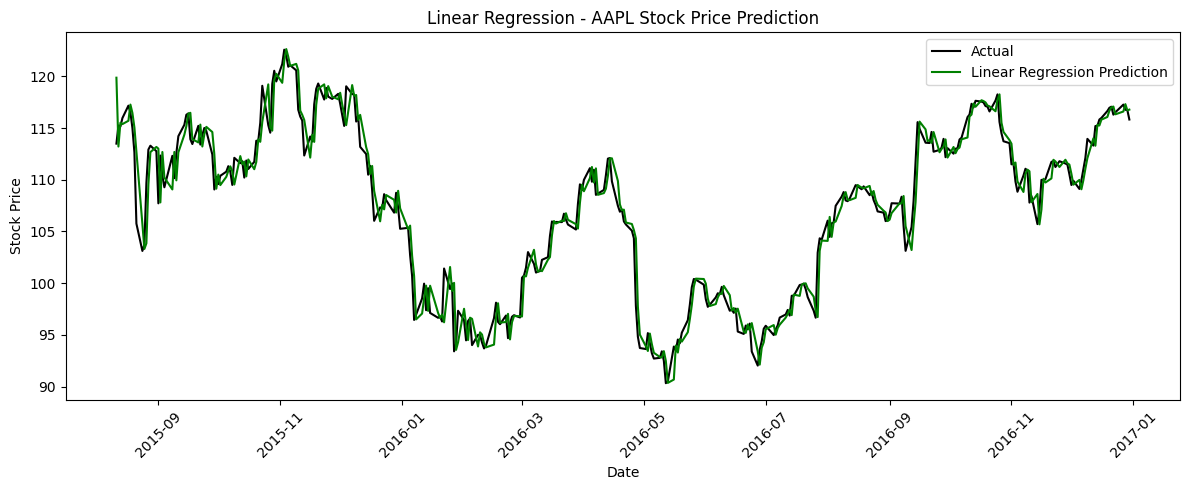

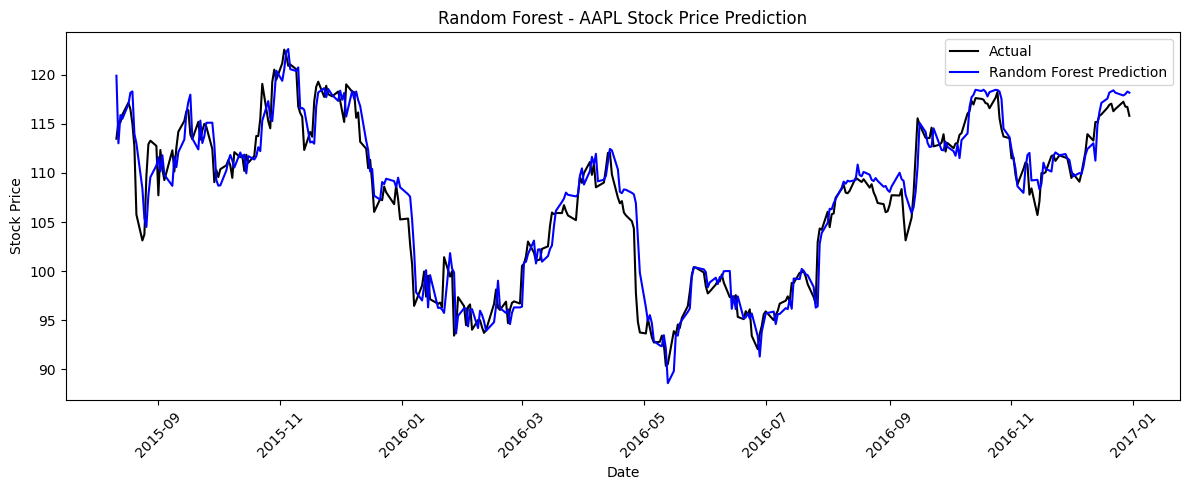

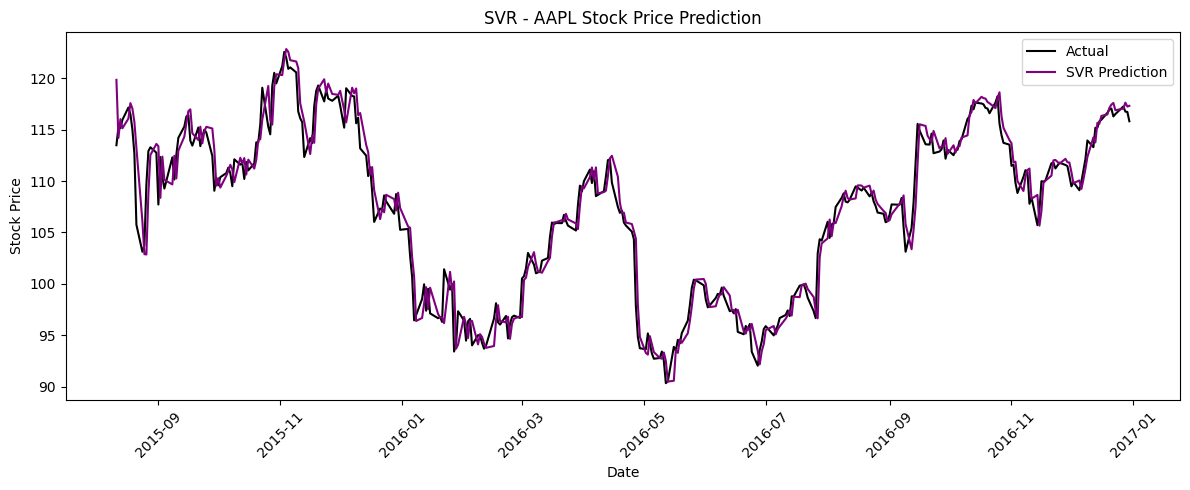

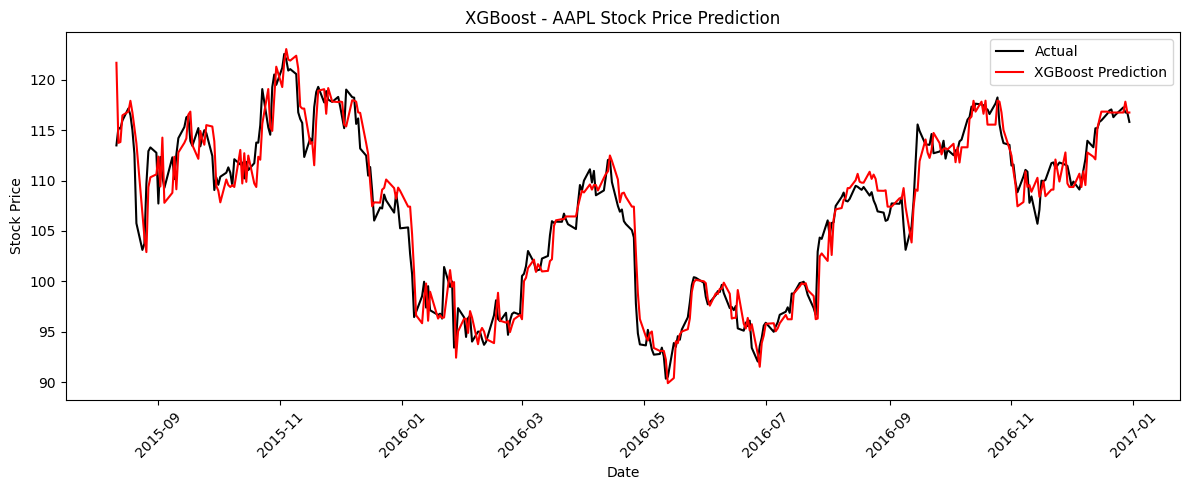

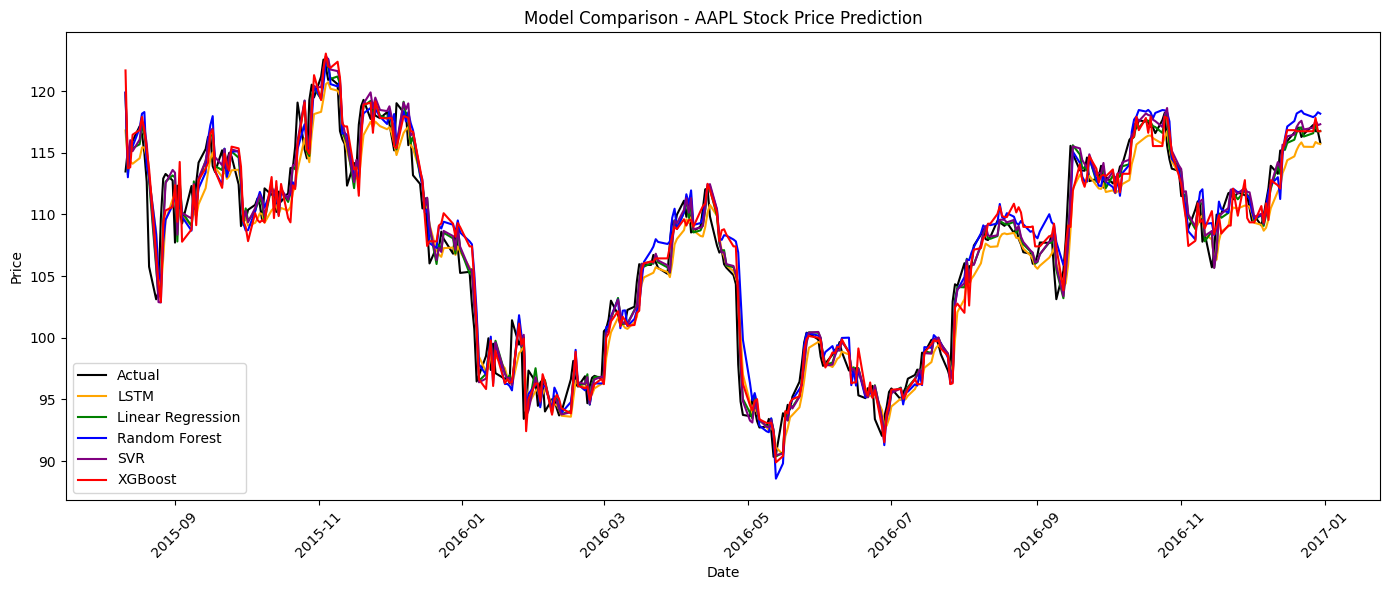


Model Performance Comparison:
               Model     MSE  R² Score
0               LSTM  4.1789    0.9341
1  Linear Regression  2.9590    0.9533
2      Random Forest  4.3063    0.9321
3                SVR  3.1655    0.9501
4            XGBoost  4.2546    0.9329


In [ ]:
# --- Import Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam



Historical stock price data and filters it to include only major tech companies (Apple, Google, Microsoft, Amazon). Visualizes the closing prices of selected tech stocks over time to observe trends and fluctuations.

In [ ]:
# --- Load and Prepare Dataset ---
prices = pd.read_csv(f"{dgawlik_nyse_path}/prices-split-adjusted.csv", parse_dates=['date'])

# Focus on major tech stocks
symbols = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
df = prices[prices['symbol'].isin(symbols)]

# Plot stock trends
plt.figure(figsize=(12, 6))
for symbol in symbols:
    symbol_df = df[df['symbol'] == symbol]
    plt.plot(symbol_df['date'], symbol_df['close'], label=symbol)
plt.title('Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

Filters the dataset for Apple Inc. (AAPL), selects only the date and closing price columns, and sets the date as the index for time series analysis. Lag features are generated from past closing prices (1 to 5 days) to help predict future prices. Rows with missing values are dropped. The lag columns are used as features (X) and the current close price as the target (y). Dates are stored for later visualization. The dataset is split into training and testing sets without shuffling to preserve the time order. Test dates are also extracted for plotting. The features are standardized using StandardScaler to ensure all values are on the same scale, improving model performance.

In [ ]:
# Filter for Apple Inc. (AAPL)
df = prices[prices['symbol'] == 'AAPL'][['date', 'close']].sort_values('date')
df.set_index('date', inplace=True)

# Create lag features
for i in range(1, 6):
    df[f'lag_{i}'] = df['close'].shift(i)
df.dropna(inplace=True)

# Feature and target split
X = df[[f'lag_{i}' for i in range(1, 6)]]
y = df['close']
dates = df.index

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
test_dates = dates[-len(y_test):]

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Reshape input for LSTM, then define and train a Sequential model using a single LSTM layer to learn temporal patterns in stock price data. Generate predictions using the trained LSTM model and evaluate performance using MSE and R² metrics. Train a linear regression model using standardized features to serve as a baseline for comparison. Train a Random Forest Regressor with 100 decision trees to capture nonlinear relationships in the data. Use SVR with RBF kernel and tuned hyperparameters to model complex relationships in the data. Train an XGBoost Regressor with boosted decision trees to achieve high performance on structured data.

In [ ]:
# --- Train Models ---

# 1. LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(0.01), loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, verbose=1)

y_lstm_pred = lstm_model.predict(X_test_lstm)
lstm_mse = mean_squared_error(y_test, y_lstm_pred)
lstm_r2 = r2_score(y_test, y_lstm_pred)

# 2. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_lr_pred = lr_model.predict(X_test_scaled)

# 3. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_rf_pred = rf_model.predict(X_test_scaled)

# 4. SVR
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)
y_svr_pred = svr_model.predict(X_test_scaled)

# 5. XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_xgb_pred = xgb_model.predict(X_test_scaled)

This function generates separate line plots comparing actual stock prices with predictions from each model to analyze their performance visually.

In [ ]:
# --- Individual Plots ---

def plot_model_preds(model_name, y_pred, color):
    plt.figure(figsize=(12, 5))
    plt.plot(test_dates, y_test, label='Actual', color='black')
    plt.plot(test_dates, y_pred, label=f'{model_name} Prediction', color=color)
    plt.title(f"{model_name} - AAPL Stock Price Prediction")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_model_preds("LSTM", y_lstm_pred, "orange")
plot_model_preds("Linear Regression", y_lr_pred, "green")
plot_model_preds("Random Forest", y_rf_pred, "blue")
plot_model_preds("SVR", y_svr_pred, "purple")
plot_model_preds("XGBoost", y_xgb_pred, "red")

This plot overlays predictions from all models along with the actual AAPL stock prices to visually compare model performance on the same timeline

In [ ]:
# --- Combined Comparison Plot ---
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test, label='Actual', color='black')
plt.plot(test_dates, y_lstm_pred, label='LSTM', color='orange')
plt.plot(test_dates, y_lr_pred, label='Linear Regression', color='green')
plt.plot(test_dates, y_rf_pred, label='Random Forest', color='blue')
plt.plot(test_dates, y_svr_pred, label='SVR', color='purple')
plt.plot(test_dates, y_xgb_pred, label='XGBoost', color='red')
plt.title("Model Comparison - AAPL Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This table summarizes the Mean Squared Error (MSE) and R² Score for each model to quantitatively compare their prediction accuracy

In [ ]:
# --- Evaluation Table ---
results = pd.DataFrame({
    'Model': ['LSTM', 'Linear Regression', 'Random Forest', 'SVR', 'XGBoost'],
    'MSE': [
        mean_squared_error(y_test, y_lstm_pred),
        mean_squared_error(y_test, y_lr_pred),
        mean_squared_error(y_test, y_rf_pred),
        mean_squared_error(y_test, y_svr_pred),
        mean_squared_error(y_test, y_xgb_pred)
    ],
    'R² Score': [
        r2_score(y_test, y_lstm_pred),
        r2_score(y_test, y_lr_pred),
        r2_score(y_test, y_rf_pred),
        r2_score(y_test, y_svr_pred),
        r2_score(y_test, y_xgb_pred)
    ]
})

print("\nModel Performance Comparison:")
print(results.round(4))